<a href="https://colab.research.google.com/github/Ankan1998/CovZer/blob/master/Covid_19_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using pytorch detecting Covid-19 Infected Lungs from Normal Lungs with Chest X-Ray**

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(torch.__version__)

In [4]:
import os 
import zipfile

### **Kaggle Preprocessing**

In [ ]:
# Upload your own API from Kaggle
from google.colab import files
uploaded=files.upload()

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Importing kaggle Data Train Set

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p "/tmp"

In [9]:
local_zip='/tmp/covid19-radiography-database.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [10]:
!mkdir "/tmp/COVID-19 Radiography Database/Xray_train_data"

In [11]:
!mv "/tmp/COVID-19 Radiography Database/COVID-19" "/tmp/COVID-19 Radiography Database/Xray_train_data"

In [12]:
!mv "/tmp/COVID-19 Radiography Database/NORMAL" "/tmp/COVID-19 Radiography Database/Xray_train_data"

In [13]:
!mv "/tmp/COVID-19 Radiography Database/Xray_train_data" "/tmp"

## **Starting Actual work**

In [14]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

### Directing to Train Folder
##### Works similiar as ImageData Generator of Keras

In [15]:
# Defining transform to resize 1024x1024 to 128x128
# To change to Tensor
transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])

In [16]:
dataset=ImageFolder("/tmp/Xray_train_data",transform=transform)

In [ ]:
len(dataset)

In [18]:
# Checking For Samples
img0,label0=dataset[0]
print(img0.shape,label0)
img1,label1=dataset[1200]
print(img1.shape,label1)
print("*"*60)
print(dataset.classes)#list out all the classes

torch.Size([3, 64, 64]) 0
torch.Size([3, 64, 64]) 1
************************************************************
['COVID-19', 'NORMAL']


label--> NORMAL


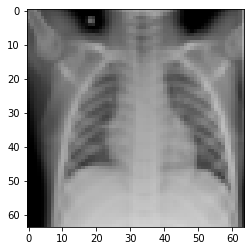

In [19]:
def show(img,label):
  print("label-->",dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

show(*dataset[1441])
# 0-->Covid-19;1-->Normal

### Splitting Validation Set from Training Set

In [20]:
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
val_per=0.5
train_indices,validation_indices=split_train_val(len(dataset),val_per,randomness)
print(validation_indices[:5])

[ 850  746 1175  343  793]


In [21]:
from torch.utils.data.sampler import SubsetRandomSampler #samples randomly from given indices
from torch.utils.data.dataloader import DataLoader # loads the data from sampler

In [22]:
batch_size=32
# Training Part
train_sampler=SubsetRandomSampler(train_indices)
train_ds=DataLoader(dataset,batch_size,sampler=train_sampler)

# Validation Part
val_sampler=SubsetRandomSampler(validation_indices)
val_ds=DataLoader(dataset,batch_size,sampler=val_sampler)

### Optional: To see one batch of image

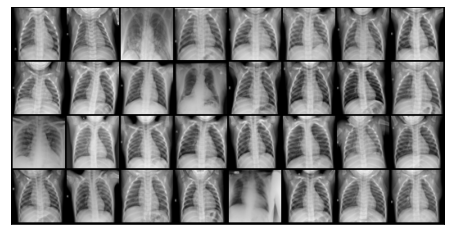

In [23]:
from torchvision.utils import make_grid
def one_batch(data_load):
  for imgs,lbls in data_load:
    fig,ax=plt.subplots(figsize=(8,4))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(imgs,8).permute(1,2,0))
    break
one_batch(train_ds)

## **Applying CNN**

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
# 1st layer of Conv2d
# 1st Argument is number of color channel for RGB=3, for BW=1
# 2nd Argument if number of filters, 3rd is filter size
# how to calculate its output directly to Linear Unit
# image=3x64x64-->64-3(filter_size)+1=62. So, output is 62x62xnumber of filter
# then 62x62xnum_of_filter-->maxpool(2,2)-->62/2=31-->32*31*31
# for same layer number of filter of output is input of new channel
# for conv to linear layer the above calculation is reqd.

"""
# Used nn.Sequential for implementation
model=nn.Sequential(
        nn.Conv2d(3,8,3), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(start_dim=1), #.view(-1,)
        nn.Linear(8*31*31,2)

)
"""
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3)
    self.out=nn.Linear(in_features=8*31*31,out_features=2)

  def forward(self,l):

    # 1 Conv layer
    l=self.conv1(l)
    l=F.relu(l)
    l=F.max_pool2d(l,kernel_size=2)

    # linear and final layer
    l=l.reshape(-1,8*31*31)
    l=self.out(l)

    return l

In [26]:
model=ConvNet()

In [ ]:
def default_device():
  if torch.cuda.is_available():
    return torch.device("cuda:0")
  else:
    return torch.device("cpu")

device=default_device()

In [ ]:
# Loading model on GPU
model.to(device)

In [31]:
# Define loss and optimizer
import torch.optim as optim
loss_type = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(15):  
# loop over the dataset multiple times
    print(epoch)
    for i, data in enumerate(train_ds):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #labels=torch.unsqueeze(labels, 1)
        #loss = loss_type(outputs, labels.type_as(outputs))
        loss = loss_type(outputs, labels)
        loss.backward()
        optimizer.step()
        

print('Finished Training')

In [ ]:
right = 0
total = 0
with torch.no_grad():
    for data in val_ds:
        images, labels = data
        #images=images.cuda()
        #labels=labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        right += (predicted == labels).sum().item()

print('Accuracy on the validation images: %d %%' % (
    100 * right / total))

## **Importing Test data and testing on it**
#### This is completely from different source from train,val data

In [ ]:
!kaggle datasets download -d fusicfenta/chest-xray-for-covid19-detection -p "/tmp"

In [ ]:
local_zip='/tmp/chest-xray-for-covid19-detection.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
!ls "/tmp/Dataset"

In [ ]:
!mkdir "/tmp/Xray_val_data"

In [ ]:
!mv "/tmp/Dataset/Train/Covid" "/tmp/Xray_val_data"

In [ ]:
!mv "/tmp/Dataset/Train/Normal" "/tmp/Xray_val_data"

In [ ]:
!ls "/tmp/Xray_val_data"

In [ ]:
transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])
test_dataset=ImageFolder("/tmp/Xray_val_data",transform=transform)

In [ ]:
len(test_dataset)

In [ ]:
# Checking For Samples
img0,label0=test_dataset[0]
print(img0.shape,label0)
img1,label1=test_dataset[150]
print(img1.shape,label1)
print("*"*60)
print(test_dataset.classes)#list out all the classes

In [ ]:
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
test_per=0.5
test1_indices,test2_indices=split_train_val(len(test_dataset),test_per,randomness)
print(test2_indices[:5])

In [ ]:
batch_size=32
# Training Part
test1_sampler=SubsetRandomSampler(test1_indices)
test1_ds=DataLoader(test_dataset,batch_size,sampler=test1_sampler)

test2_sampler=SubsetRandomSampler(test2_indices)
test2_ds=DataLoader(test_dataset,batch_size,sampler=test2_sampler)

In [ ]:
right = 0
total = 0
with torch.no_grad():
    for data in test1_ds:
        images, labels = data
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        right += (predicted == labels).sum().item()

print('Accuracy on the Test images: %d %%' % (
    100 * right / total))